<a href="https://colab.research.google.com/github/LuanPCunha/TCC/blob/main/Treinamento_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloads e imports

In [1]:
# !pip install tensorflow
# !pip install keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import json
import sklearn
import numpy as np
import pandas as pd
from numpy import loadtxt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras import layers
from keras.layers import Dropout, Conv1D, MaxPooling1D, Flatten, Dense, SpatialDropout1D, BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, RMSprop, Adagrad, Adamax, Nadam, Ftrl
from keras.models import Sequential
from keras.layers.embeddings import Embedding

from mlxtend.plotting import plot_confusion_matrix
from keras.callbacks import Callback, ModelCheckpoint, CSVLogger
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

In [4]:
def tokenize(tweets_list):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(tweets_list)
    return tokenizer.texts_to_sequences(tweets_list), tokenizer

In [5]:
def pad(text_tokenized, length=None):
    return pad_sequences(text_tokenized, maxlen=length, padding='post')

In [6]:
def preprocess(tweets_list, max_text_length):
    
    preprocess_tweets_list, tweets_list_tokenizer = tokenize(tweets_list)

    preprocess_tweets_list = pad(preprocess_tweets_list, length=max_text_length)

    return preprocess_tweets_list, tweets_list_tokenizer

In [7]:
def logits_to_text(logits, tokenizer):
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

In [8]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            self.score = roc_auc_score(self.y_val, y_pred)
            self.false_positive_rate, self.true_positive_rate, _ = roc_curve(self.y_val, y_pred)          

# Carrega arquivo de saída (resultados)

In [9]:
# CONSTANTES DOS RESULTADOS
REDE = 'LSTM'

BASE_0 = 'BASE 0'
BASE_1 = 'BASE 1'
BASE_2 = 'BASE 2'

# Caminho arquivo de saída
PATH_ARQ_SAIDA = "/content/drive/MyDrive/TCC/resultados/resultados.csv"

#  rede base otimizador acuracia val_loss learning_rate dropout batch_size roc_curve train_resume confusion_matrix
resultados = pd.read_csv(PATH_ARQ_SAIDA, index_col=0)
resultados.head()

,rede,base,otimizador,acuracia,val_loss,learning_rate,dropout,batch_size,roc_curve,train_resume,confusion_matrix
0,CNN,BASE 2,Nadam,0.938061,0.201470,0.0001,0.1,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 1000, ""01"": 58, ""10"": 73, ""11"": 984}"
1,CNN,BASE 2,Nadam,0.933333,0.198454,0.0001,0.2,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 981, ""01"": 77, ""10"": 64, ""11"": 993}"
2,CNN,BASE 2,Nadam,0.939007,0.197918,0.0001,0.3,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 999, ""01"": 59, ""10"": 70, ""11"": 987}"
3,CNN,BASE 2,RMSProp,0.933333,0.215135,0.0001,0.1,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 981, ""01"": 77, ""10"": 64, ""11"": 993}"
4,CNN,BASE 2,RMSProp,0.932388,0.217581,0.0001,0.2,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 971, ""01"": 87, ""10"": 56, ""11"": 1001}"


# Carrega base

In [10]:
# Base1 Com StopWords
PATH_BASE1_JUNTO_COM_DA_LEILA_BALANCEADA = "/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base1JuntaHateENotHateDaLeila_balanceada.csv"
#MATRIZ_CBOW_300_BASE_1 = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base1JuntaHateENotHateDaLeila_balanceada_CBOW300.CSV", delimiter=',')

# Base2 Sem StopWords
PATH_BASE2_LEILA_LIMPISSIMA_BALANCEADA = "/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base2_maior4_menor25_limpissima_balanceada.csv"
#MATRIZ_CBOW_300_BASE_2_LEILA = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base2_maior4_menor25_limpissima_balanceada_CBOW300.CSV", delimiter=',')

PATH_BASE_1_CLASSIFICADA_BALANCEADA = r"/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base1_classificada_balanceada.csv" #entrada

PATH_BASE_2_CLASSIFICADA_BALANCEADA = r"/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base2_classificada_balanceada.csv" #entrada
MATRIZ_CBOW_300_BASE_2 = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base2_classificada_balanceada_CBOW300.csv", delimiter=',') #saida

# Execução modelo

In [11]:
tweets = pd.read_csv(PATH_BASE_2_CLASSIFICADA_BALANCEADA, index_col=0)
text_column = tweets['text']
text_column

0        retwet bahia fazer sendo governada pt sei baia...
1        k imagine atitude mental negativa f idiota fec...
2        general heleno é bolsonaro rosna late late lat...
3        alan ser cara pau achar havendo ruptura nesse ...
4        canalhascomunistas caçarão chapa presidencialn...
                               ...                        
10569               af hein amiga mandar outro número mail
10570    egoísmo é grande parte produto sociedade émile...
10571    abençoado novo linda querida obrigada carinho ...
10572                              leva gente amorzinhos d
10573                                   k k ata meia sonsa
Name: text, Length: 10574, dtype: object

In [12]:
# Pega a média de caracteres dos tweets de toda a base
max_text_length = int(text_column.apply(lambda x: len(str(x).split(' '))).max())
max_text_length

55

In [13]:
output_label = tweets['label']
input_data, text_tokenizer = preprocess(text_column, None)
    
text_vocab_size = len(text_tokenizer.word_index)
print("Vocabulary size:", text_vocab_size)

Vocabulary size: 19043


In [14]:
# parametros tunning:
BATCH_SIZE = [32, 64]
LEARN_RATE = [0.0001, 0.001]
OTMIZADORES = ['Nadam', 'RMSProp', 'SGD']
DROPOUT = [0.1, 0.2, 0.3]

# parametros estaticos:
EPOCHS = 10
VAL_AND_TST_SIZE = 0.2 # Fazer na mão
EMBEDDING_DIMENSION = 300  
MAX_TEXT_SIZE = max_text_length 
VOCAB_SIZE = text_vocab_size

In [15]:
def optimize (optimize, learning_rate):
  if optimize == 'Nadam':
    return Nadam(learning_rate=learning_rate, name="Nadam")
  
  if optimize == 'RMSProp':
    return RMSprop(learning_rate=learning_rate, name="RMSprop")
  
  if optimize == 'SGD':
    return SGD(learning_rate=learning_rate, name="SGD")

In [16]:
def create_lstm (vocab_size, embedding_dimen, max_text_size, dropout_rate ):

  modelo = keras.Sequential([
    keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIMENSION, input_length=max_text_size),
    # keras.layers.Embedding(input_dim=MATRIZ_CBOW_300_BASE_2.shape[0],
                            # output_dim=MATRIZ_CBOW_300_BASE_2.shape[1],
                            # weights=[MATRIZ_CBOW_300_BASE_2],
                            # embeddings_initializer=keras.initializers.Constant(MATRIZ_CBOW_300_BASE_2),
                            # input_length=max_text_size,
                            # trainable=True),
    keras.layers.LSTM(max_text_size, dropout=dropout_rate, name="LSTM"),
    keras.layers.Dense(1, activation='sigmoid')
    ])

  return modelo  

In [17]:
def train_model(input_data, output_label, embedding_dimen, batch_size, epochs, validation_and_test_size, learning_rate, optimizer, dropout_rate):
    
    x_main, x_test, y_main, y_test = train_test_split(input_data, output_label, test_size=0.2, stratify=output_label, random_state=42)
    
    x_train, x_val, y_train, y_val = train_test_split(x_main, y_main, test_size=0.2, stratify=y_main, random_state=42)

    opt = optimize(optimizer, learning_rate)
    
    model = create_lstm(VOCAB_SIZE, EMBEDDING_DIMENSION, MAX_TEXT_SIZE, dropout_rate)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, metrics=['accuracy'])        
    
    ra_val = RocAucEvaluation(validation_data=(x_val, y_val), interval = 1)
    
    csv_logger = CSVLogger('log.csv', append=False, separator=';')                                                                                       
    
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), verbose=0, use_multiprocessing=True,  callbacks = [ra_val, csv_logger])
    
    scores = model.evaluate(x_test, y_test, verbose=0)
    
    return history, model, x_test, y_test, ra_val, scores, csv_logger

In [18]:
# plot dos gráficos
for BS in BATCH_SIZE:
  for LR in LEARN_RATE:
    for OT in OTMIZADORES:
      for DO in DROPOUT:
        
        history, model1, x_test, y_test, ra_val, scores, csv_logger = train_model(input_data, output_label, EMBEDDING_DIMENSION, BS, EPOCHS, VAL_AND_TST_SIZE, LR, OT, DO)

        #
        y_predito = model1.predict(x_test).round()
        y_gabarito = y_test
        
        # Parâmetros
        # rede base otimizador acuracia val_loss learning_rate dropout batch_size roc_curve train_resume confusion_matrix
        NOME_REDE = REDE
        NOME_BASE = BASE_2
        NOME_OTIMIZADOR = OT
        ACURACIA = scores[1]
        VAL_LOSS = scores[0] 
        LEARNING_RATE = LR
        DROPOUT_RATE = DO
        BATCH = BS
        ROC_CURVE = json.dumps({
            "false_positive_rate": list(ra_val.false_positive_rate),
            "true_positive_rate": list(ra_val.true_positive_rate),
            "score": ra_val.score})
        TRAIN_RESUME = json.dumps(pd.read_csv('log.csv',sep=';').to_dict()) 
        
        confusion = confusion_matrix(y_gabarito, y_predito)
        CONFUSION_MATRIX = json.dumps({
            "00": int(confusion[0][0]),
            "01": int(confusion[0][1]),
            "10": int(confusion[1][0]),
            "11": int(confusion[1][1])
        })
 
        # Salvando resultado do modelo
        registro_resultado = {resultados.columns[0]: NOME_REDE, 
                              resultados.columns[1]: NOME_BASE, 
                              resultados.columns[2]: NOME_OTIMIZADOR,
                              resultados.columns[3]: ACURACIA, 
                              resultados.columns[4]: VAL_LOSS,
                              resultados.columns[5]: LEARNING_RATE,
                              resultados.columns[6]: DROPOUT_RATE,
                              resultados.columns[7]: BATCH,
                              resultados.columns[8]: ROC_CURVE,
                              resultados.columns[9]: TRAIN_RESUME,
                              resultados.columns[10]: CONFUSION_MATRIX
                            }

        resultados = resultados.append(registro_resultado, ignore_index=True)

In [19]:
resultados

,rede,base,otimizador,acuracia,val_loss,learning_rate,dropout,batch_size,roc_curve,train_resume,confusion_matrix
0,CNN,BASE 2,Nadam,0.938061,0.201470,0.0001,0.1,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 1000, ""01"": 58, ""10"": 73, ""11"": 984}"
1,CNN,BASE 2,Nadam,0.933333,0.198454,0.0001,0.2,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 981, ""01"": 77, ""10"": 64, ""11"": 993}"
2,CNN,BASE 2,Nadam,0.939007,0.197918,0.0001,0.3,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 999, ""01"": 59, ""10"": 70, ""11"": 987}"
3,CNN,BASE 2,RMSProp,0.933333,0.215135,0.0001,0.1,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 981, ""01"": 77, ""10"": 64, ""11"": 993}"
4,CNN,BASE 2,RMSProp,0.932388,0.217581,0.0001,0.2,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 971, ""01"": 87, ""10"": 56, ""11"": 1001}"
...,...,...,...,...,...,...,...,...,...,...,...
67,LSTM,BASE 2,RMSProp,0.869031,0.511743,0.0010,0.2,64,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 908, ""01"": 150, ""10"": 127, ""11"": 930}"
68,LSTM,BASE 2,RMSProp,0.557447,0.695758,0.0010,0.3,64,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0011...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 691, ""01"": 367, ""10"": 569, ""11"": 488}"
69,LSTM,BASE 2,SGD,0.500236,0.693156,0.0010,0.1,64,"{""false_positive_rate"": [0.0, 0.00118203309692...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 1058, ""01"": 0, ""10"": 1057, ""11"": 0}"
70,LSTM,BASE 2,SGD,0.499764,0.693147,0.0010,0.2,64,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0023...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 0, ""01"": 1058, ""10"": 0, ""11"": 1057}"


In [20]:
# Caso queira deletar uma linha use o código abaixo
# Use a propriedade label para especificar o índice da linha
#resultados = resultados.drop(labels=1, axis=0)
#resultados = resultados.reset_index(drop=True)
#resultados

In [21]:
# Salva arquivo de saída
resultados.to_csv(PATH_ARQ_SAIDA)

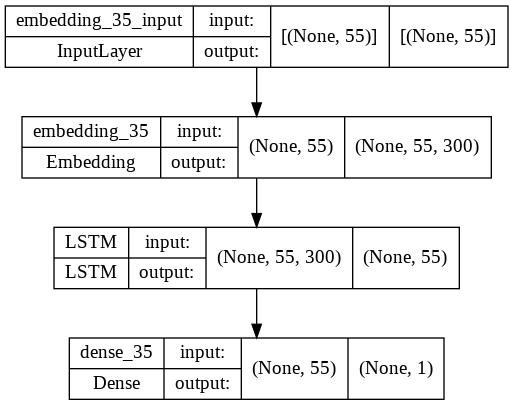

In [22]:
tf.keras.utils.plot_model(model1, to_file='/meuarquivo.png', show_shapes=True)